In [1]:
import itertools as it
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset, random_split
import attention as att
import torch.optim as optim
from tqdm import trange
from matplotlib.colors import LogNorm

In [2]:
# For same initialization of weights/biases of model
torch.manual_seed(seed=999)
torch.set_float32_matmul_precision('high')

In [3]:
# input_CG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_coarse_scale_dynamics.npy')
# target_FG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_fine_scale_dynamics.npy') 
#input_CG = np.load('/pscratch/sd/h/hbassi/GS_model_data_coarse_scale_dynamics.npy')
#target_FG = np.load('/pscratch/sd/h/hbassi/GS_model_data_fine_scale_dynamics.npy')
input_CG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_coarse_scale_dynamics_TT_bd=8.npy')
target_FG = np.load('/pscratch/sd/h/hbassi/GS_model_multi_traj_data_fine_scale_dynamics_TT_bd=32.npy')
input_CG.shape, target_FG.shape

((500, 1500, 100, 100), (500, 1500, 100, 100))

In [4]:
# input_CG = input_CG.reshape((87, 400, 1, 48, 48))[:, 0, :, :, :]
# target_FG = target_FG.reshape((87, 400, 1, 128, 128))[:, 0, :, :, :]
input_CG = np.expand_dims(input_CG[:, 1250, :, :], 1)
target_FG =  np.expand_dims(target_FG[:, 1250, :, :],1)

In [5]:
input_CG.shape, target_FG.shape

((500, 1, 100, 100), (500, 1, 100, 100))

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # 64, 64 for upsampling and add a ReLU
            nn.Conv2d(64,1, kernel_size=3, padding=1)
        )
        # self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        # self.dec2 = nn.Sequential(
        #     nn.Conv2d(64, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 1, kernel_size=3, padding=1)
        # )
        
    def forward(self, x):
        enc = self.encoder(x)
        mid = self.middle(enc)
        up1 = self.up1(mid)
        dec1 = self.dec1(up1)
        #up2 = self.up2(dec1)  # Upsample 
        #dec2 = self.dec2(up2)
        return dec1
unet = UNet()

In [7]:
device = 'cuda:0'
input_CG_tensor = torch.tensor(input_CG, dtype=torch.float32).to(device)
target_FG_tensor = torch.tensor(target_FG, dtype=torch.float32).to(device)

In [8]:
def generate_random_mask(image, mask_fraction=0.3):
    mask = torch.ones_like(image)
    num_pixels = image.shape[-2] * image.shape[-1]
    num_masked_pixels = int(mask_fraction * num_pixels)
    
    # Randomly select pixels to mask
    mask_indices = torch.randperm(num_pixels)[:num_masked_pixels]
    mask_indices = mask_indices.to(image.device)
    
    # Flatten the image and mask
    flat_mask = mask.view(-1)
    flat_mask[mask_indices] = 0  # Set the mask pixels to 0
    mask = flat_mask.view_as(mask)
    
    # Apply the mask
    masked_image = image * mask
    return masked_image, mask


In [9]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, data, mask_fraction=0.3):
        self.data = data
        self.mask_fraction = mask_fraction

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        masked_image, mask = generate_random_mask(image, self.mask_fraction)
        return masked_image, image  # Masked image as input, original as target


In [10]:
masked_dataset = MaskedDataset(input_CG_tensor, mask_fraction=0.3)
# Split into training and validation datasets
train_size = int(0.8 * len(masked_dataset))
val_size = len(masked_dataset) - train_size
train_masked_dataset, val_masked_dataset = random_split(masked_dataset, [train_size, val_size])

train_masked_dataloader = DataLoader(train_masked_dataset, batch_size=16, shuffle=True)
val_masked_dataloader = DataLoader(val_masked_dataset, batch_size=16, shuffle=False)

In [11]:
# Create the full dataset
train_window = 450
#train_window = 700
dataset = TensorDataset(input_CG_tensor[:train_window], target_FG_tensor[:train_window])

# 80% training, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [12]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

In [13]:
# Training loop
num_epochs = 10000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [14]:
total_params = sum(p.numel() for p in unet.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 329345


In [15]:
unet = unet.to(device)
unet = torch.compile(unet)

In [16]:
# unet.load_state_dict(torch.load('unet_epoch_800.pth'))

In [17]:
# Pre-Training Loop
pretrain_epochs = 10000
pretrain_optimizer = optim.Adam(unet.parameters(), lr=0.001)
pretrain_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(pretrain_optimizer, T_max=pretrain_epochs, eta_min=1e-6)

for epoch in trange(pretrain_epochs):
    unet.train()
    pretrain_loss = 0.0

    for masked_data, original_data in train_masked_dataloader:
        masked_data = masked_data.to(device)
        original_data = original_data.to(device)

        output = unet(masked_data)
        loss = criterion(output, original_data)  # Learn to reconstruct the original image

        pretrain_optimizer.zero_grad()
        loss.backward()
        pretrain_optimizer.step()

        pretrain_loss += loss.item()

    pretrain_scheduler.step()

    if epoch % 100 == 0:
        print(f"[Pre-Training] Epoch [{epoch+1}/{pretrain_epochs}], Loss: {pretrain_loss / len(train_masked_dataloader):.8f}")


  0%|          | 2/10000 [00:12<13:57:48,  5.03s/it]

[Pre-Training] Epoch [1/10000], Loss: 0.34686125


  1%|          | 102/10000 [00:30<30:05,  5.48it/s] 

[Pre-Training] Epoch [101/10000], Loss: 0.00702721


  2%|▏         | 202/10000 [00:48<29:40,  5.50it/s]

[Pre-Training] Epoch [201/10000], Loss: 0.00812975


  3%|▎         | 302/10000 [01:06<30:10,  5.36it/s]

[Pre-Training] Epoch [301/10000], Loss: 0.00442142


  4%|▍         | 402/10000 [01:25<30:17,  5.28it/s]

[Pre-Training] Epoch [401/10000], Loss: 0.00351969


  5%|▌         | 502/10000 [01:44<29:29,  5.37it/s]

[Pre-Training] Epoch [501/10000], Loss: 0.00338683


  6%|▌         | 602/10000 [02:03<28:56,  5.41it/s]

[Pre-Training] Epoch [601/10000], Loss: 0.00667342


  7%|▋         | 702/10000 [02:22<28:49,  5.37it/s]

[Pre-Training] Epoch [701/10000], Loss: 0.00490715


  8%|▊         | 802/10000 [02:40<28:47,  5.32it/s]

[Pre-Training] Epoch [801/10000], Loss: 0.00452046


  9%|▉         | 902/10000 [02:59<27:56,  5.43it/s]

[Pre-Training] Epoch [901/10000], Loss: 0.00290059


 10%|█         | 1002/10000 [03:17<27:39,  5.42it/s]

[Pre-Training] Epoch [1001/10000], Loss: 0.00451906


 11%|█         | 1102/10000 [03:36<28:30,  5.20it/s]

[Pre-Training] Epoch [1101/10000], Loss: 0.00455394


 12%|█▏        | 1202/10000 [03:55<27:03,  5.42it/s]

[Pre-Training] Epoch [1201/10000], Loss: 0.00257258


 13%|█▎        | 1302/10000 [04:15<26:53,  5.39it/s]

[Pre-Training] Epoch [1301/10000], Loss: 0.00247438


 14%|█▍        | 1402/10000 [04:35<26:52,  5.33it/s]

[Pre-Training] Epoch [1401/10000], Loss: 0.00311066


 15%|█▌        | 1502/10000 [04:56<26:58,  5.25it/s]

[Pre-Training] Epoch [1501/10000], Loss: 0.00252944


 16%|█▌        | 1602/10000 [05:17<31:05,  4.50it/s]

[Pre-Training] Epoch [1601/10000], Loss: 0.00459413


 17%|█▋        | 1702/10000 [05:38<27:36,  5.01it/s]

[Pre-Training] Epoch [1701/10000], Loss: 0.00244228


 18%|█▊        | 1802/10000 [05:58<26:08,  5.23it/s]

[Pre-Training] Epoch [1801/10000], Loss: 0.00306352


 19%|█▉        | 1901/10000 [06:19<25:22,  5.32it/s]

[Pre-Training] Epoch [1901/10000], Loss: 0.00206099


 20%|██        | 2001/10000 [06:42<26:25,  5.04it/s]

[Pre-Training] Epoch [2001/10000], Loss: 0.00357914


 21%|██        | 2102/10000 [07:02<28:39,  4.59it/s]

[Pre-Training] Epoch [2101/10000], Loss: 0.00203841


 22%|██▏       | 2201/10000 [07:23<24:24,  5.32it/s]

[Pre-Training] Epoch [2201/10000], Loss: 0.00220648


 23%|██▎       | 2302/10000 [07:44<25:33,  5.02it/s]

[Pre-Training] Epoch [2301/10000], Loss: 0.00219986


 24%|██▍       | 2402/10000 [08:02<23:14,  5.45it/s]

[Pre-Training] Epoch [2401/10000], Loss: 0.00270384


 25%|██▌       | 2502/10000 [08:21<22:22,  5.58it/s]

[Pre-Training] Epoch [2501/10000], Loss: 0.00337479


 26%|██▌       | 2602/10000 [08:39<22:45,  5.42it/s]

[Pre-Training] Epoch [2601/10000], Loss: 0.00319500


 27%|██▋       | 2702/10000 [08:58<23:01,  5.28it/s]

[Pre-Training] Epoch [2701/10000], Loss: 0.00192154


 28%|██▊       | 2802/10000 [09:17<22:11,  5.40it/s]

[Pre-Training] Epoch [2801/10000], Loss: 0.00191577


 29%|██▉       | 2902/10000 [09:35<21:52,  5.41it/s]

[Pre-Training] Epoch [2901/10000], Loss: 0.00187678


 30%|███       | 3002/10000 [09:55<25:11,  4.63it/s]

[Pre-Training] Epoch [3001/10000], Loss: 0.00184536


 31%|███       | 3102/10000 [10:17<25:09,  4.57it/s]

[Pre-Training] Epoch [3101/10000], Loss: 0.00201526


 32%|███▏      | 3201/10000 [10:39<22:44,  4.98it/s]

[Pre-Training] Epoch [3201/10000], Loss: 0.00297352


 33%|███▎      | 3302/10000 [10:58<20:38,  5.41it/s]

[Pre-Training] Epoch [3301/10000], Loss: 0.00185477


 34%|███▍      | 3402/10000 [11:17<20:13,  5.44it/s]

[Pre-Training] Epoch [3401/10000], Loss: 0.00241253


 35%|███▌      | 3502/10000 [11:36<20:04,  5.39it/s]

[Pre-Training] Epoch [3501/10000], Loss: 0.00168864


 36%|███▌      | 3602/10000 [11:54<19:49,  5.38it/s]

[Pre-Training] Epoch [3601/10000], Loss: 0.00223122


 37%|███▋      | 3702/10000 [12:13<19:26,  5.40it/s]

[Pre-Training] Epoch [3701/10000], Loss: 0.00241328


 38%|███▊      | 3802/10000 [12:33<19:56,  5.18it/s]

[Pre-Training] Epoch [3801/10000], Loss: 0.00270166


 39%|███▉      | 3901/10000 [12:53<20:59,  4.84it/s]

[Pre-Training] Epoch [3901/10000], Loss: 0.00185270


 40%|████      | 4002/10000 [13:16<20:03,  4.99it/s]

[Pre-Training] Epoch [4001/10000], Loss: 0.00153971


 41%|████      | 4102/10000 [13:38<20:08,  4.88it/s]

[Pre-Training] Epoch [4101/10000], Loss: 0.00191254


 42%|████▏     | 4202/10000 [13:58<17:51,  5.41it/s]

[Pre-Training] Epoch [4201/10000], Loss: 0.00169135


 43%|████▎     | 4302/10000 [14:19<17:58,  5.28it/s]

[Pre-Training] Epoch [4301/10000], Loss: 0.00145718


 44%|████▍     | 4402/10000 [14:39<17:18,  5.39it/s]

[Pre-Training] Epoch [4401/10000], Loss: 0.00143249


 45%|████▌     | 4502/10000 [14:58<16:48,  5.45it/s]

[Pre-Training] Epoch [4501/10000], Loss: 0.00144120


 46%|████▌     | 4602/10000 [15:17<16:36,  5.42it/s]

[Pre-Training] Epoch [4601/10000], Loss: 0.00156880


 47%|████▋     | 4702/10000 [15:36<16:25,  5.37it/s]

[Pre-Training] Epoch [4701/10000], Loss: 0.00147160


 48%|████▊     | 4802/10000 [15:54<16:09,  5.36it/s]

[Pre-Training] Epoch [4801/10000], Loss: 0.00138001


 49%|████▉     | 4902/10000 [16:13<15:34,  5.46it/s]

[Pre-Training] Epoch [4901/10000], Loss: 0.00139834


 50%|█████     | 5002/10000 [16:31<15:24,  5.40it/s]

[Pre-Training] Epoch [5001/10000], Loss: 0.00136887


 51%|█████     | 5102/10000 [16:50<14:43,  5.54it/s]

[Pre-Training] Epoch [5101/10000], Loss: 0.00133040


 52%|█████▏    | 5202/10000 [17:09<14:23,  5.56it/s]

[Pre-Training] Epoch [5201/10000], Loss: 0.00126986


 53%|█████▎    | 5302/10000 [17:28<14:21,  5.46it/s]

[Pre-Training] Epoch [5301/10000], Loss: 0.00142905


 54%|█████▍    | 5402/10000 [17:47<13:46,  5.56it/s]

[Pre-Training] Epoch [5401/10000], Loss: 0.00125969


 55%|█████▌    | 5502/10000 [18:07<15:12,  4.93it/s]

[Pre-Training] Epoch [5501/10000], Loss: 0.00120600


 56%|█████▌    | 5602/10000 [18:27<17:22,  4.22it/s]

[Pre-Training] Epoch [5601/10000], Loss: 0.00125456


 57%|█████▋    | 5702/10000 [18:45<12:48,  5.59it/s]

[Pre-Training] Epoch [5701/10000], Loss: 0.00126325


 58%|█████▊    | 5802/10000 [19:06<12:28,  5.61it/s]

[Pre-Training] Epoch [5801/10000], Loss: 0.00116616


 59%|█████▉    | 5902/10000 [19:26<12:25,  5.50it/s]

[Pre-Training] Epoch [5901/10000], Loss: 0.00122463


 60%|██████    | 6002/10000 [19:45<12:16,  5.43it/s]

[Pre-Training] Epoch [6001/10000], Loss: 0.00115137


 61%|██████    | 6102/10000 [20:04<11:55,  5.45it/s]

[Pre-Training] Epoch [6101/10000], Loss: 0.00117012


 62%|██████▏   | 6202/10000 [20:22<11:45,  5.39it/s]

[Pre-Training] Epoch [6201/10000], Loss: 0.00112670


 63%|██████▎   | 6302/10000 [20:42<11:25,  5.39it/s]

[Pre-Training] Epoch [6301/10000], Loss: 0.00120420


 64%|██████▍   | 6402/10000 [21:01<11:00,  5.45it/s]

[Pre-Training] Epoch [6401/10000], Loss: 0.00111527


 65%|██████▌   | 6502/10000 [21:20<12:10,  4.79it/s]

[Pre-Training] Epoch [6501/10000], Loss: 0.00113305


 66%|██████▌   | 6602/10000 [21:38<10:28,  5.41it/s]

[Pre-Training] Epoch [6601/10000], Loss: 0.00107458


 67%|██████▋   | 6702/10000 [21:57<10:15,  5.36it/s]

[Pre-Training] Epoch [6701/10000], Loss: 0.00106505


 68%|██████▊   | 6802/10000 [22:16<10:21,  5.15it/s]

[Pre-Training] Epoch [6801/10000], Loss: 0.00111967


 69%|██████▉   | 6902/10000 [22:35<09:30,  5.43it/s]

[Pre-Training] Epoch [6901/10000], Loss: 0.00102600


 70%|███████   | 7002/10000 [22:53<09:18,  5.37it/s]

[Pre-Training] Epoch [7001/10000], Loss: 0.00105556


 71%|███████   | 7102/10000 [23:11<08:47,  5.50it/s]

[Pre-Training] Epoch [7101/10000], Loss: 0.00103403


 72%|███████▏  | 7202/10000 [23:30<09:43,  4.80it/s]

[Pre-Training] Epoch [7201/10000], Loss: 0.00104865


 73%|███████▎  | 7302/10000 [23:50<08:05,  5.56it/s]

[Pre-Training] Epoch [7301/10000], Loss: 0.00098027


 74%|███████▍  | 7401/10000 [24:11<08:34,  5.05it/s]

[Pre-Training] Epoch [7401/10000], Loss: 0.00098778


 75%|███████▌  | 7502/10000 [24:32<09:32,  4.36it/s]

[Pre-Training] Epoch [7501/10000], Loss: 0.00101115


 76%|███████▌  | 7602/10000 [24:53<07:53,  5.06it/s]

[Pre-Training] Epoch [7601/10000], Loss: 0.00096508


 77%|███████▋  | 7702/10000 [25:14<07:13,  5.30it/s]

[Pre-Training] Epoch [7701/10000], Loss: 0.00100866


 78%|███████▊  | 7802/10000 [25:35<07:57,  4.60it/s]

[Pre-Training] Epoch [7801/10000], Loss: 0.00099369


 79%|███████▉  | 7902/10000 [25:56<07:14,  4.83it/s]

[Pre-Training] Epoch [7901/10000], Loss: 0.00094118


 80%|████████  | 8002/10000 [26:18<07:03,  4.71it/s]

[Pre-Training] Epoch [8001/10000], Loss: 0.00100318


 81%|████████  | 8102/10000 [26:38<06:00,  5.27it/s]

[Pre-Training] Epoch [8101/10000], Loss: 0.00093238


 82%|████████▏ | 8202/10000 [26:59<06:18,  4.75it/s]

[Pre-Training] Epoch [8201/10000], Loss: 0.00091795


 83%|████████▎ | 8302/10000 [27:20<05:28,  5.18it/s]

[Pre-Training] Epoch [8301/10000], Loss: 0.00093602


 84%|████████▍ | 8402/10000 [27:41<06:23,  4.16it/s]

[Pre-Training] Epoch [8401/10000], Loss: 0.00092343


 85%|████████▌ | 8502/10000 [28:00<04:36,  5.42it/s]

[Pre-Training] Epoch [8501/10000], Loss: 0.00090027


 86%|████████▌ | 8602/10000 [28:19<04:16,  5.45it/s]

[Pre-Training] Epoch [8601/10000], Loss: 0.00089715


 87%|████████▋ | 8702/10000 [28:37<03:56,  5.48it/s]

[Pre-Training] Epoch [8701/10000], Loss: 0.00089352


 88%|████████▊ | 8802/10000 [28:56<03:42,  5.39it/s]

[Pre-Training] Epoch [8801/10000], Loss: 0.00089568


 89%|████████▉ | 8902/10000 [29:15<03:24,  5.38it/s]

[Pre-Training] Epoch [8901/10000], Loss: 0.00090384


 90%|█████████ | 9002/10000 [29:35<03:40,  4.52it/s]

[Pre-Training] Epoch [9001/10000], Loss: 0.00089937


 91%|█████████ | 9102/10000 [29:54<02:50,  5.25it/s]

[Pre-Training] Epoch [9101/10000], Loss: 0.00088650


 92%|█████████▏| 9201/10000 [30:13<02:26,  5.46it/s]

[Pre-Training] Epoch [9201/10000], Loss: 0.00088297


 93%|█████████▎| 9302/10000 [30:32<02:10,  5.34it/s]

[Pre-Training] Epoch [9301/10000], Loss: 0.00088256


 94%|█████████▍| 9402/10000 [30:50<01:56,  5.15it/s]

[Pre-Training] Epoch [9401/10000], Loss: 0.00087979


 95%|█████████▌| 9502/10000 [31:09<01:30,  5.48it/s]

[Pre-Training] Epoch [9501/10000], Loss: 0.00087881


 96%|█████████▌| 9602/10000 [31:27<01:12,  5.47it/s]

[Pre-Training] Epoch [9601/10000], Loss: 0.00087708


 97%|█████████▋| 9702/10000 [31:46<00:54,  5.44it/s]

[Pre-Training] Epoch [9701/10000], Loss: 0.00087565


 98%|█████████▊| 9802/10000 [32:05<00:36,  5.46it/s]

[Pre-Training] Epoch [9801/10000], Loss: 0.00087591


 99%|█████████▉| 9902/10000 [32:24<00:18,  5.37it/s]

[Pre-Training] Epoch [9901/10000], Loss: 0.00087509


100%|██████████| 10000/10000 [32:42<00:00,  5.09it/s]


torch.Size([16, 1, 100, 100]) torch.Size([16, 1, 100, 100])


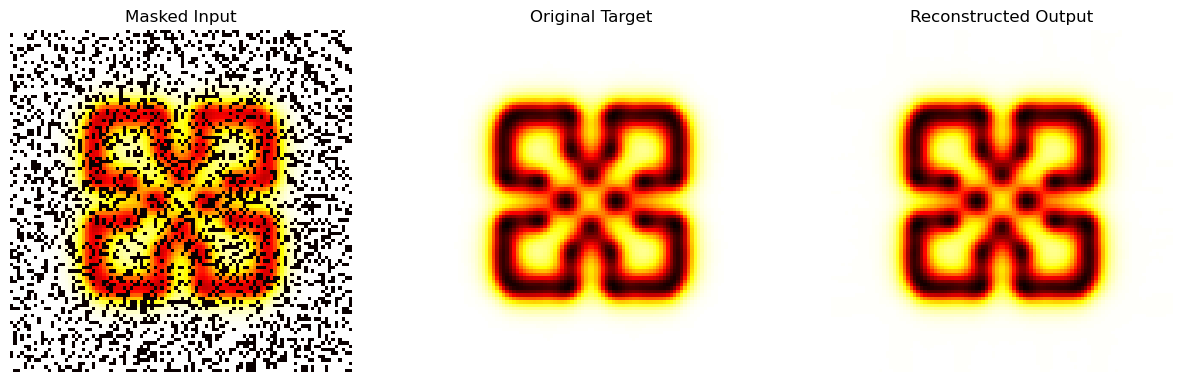

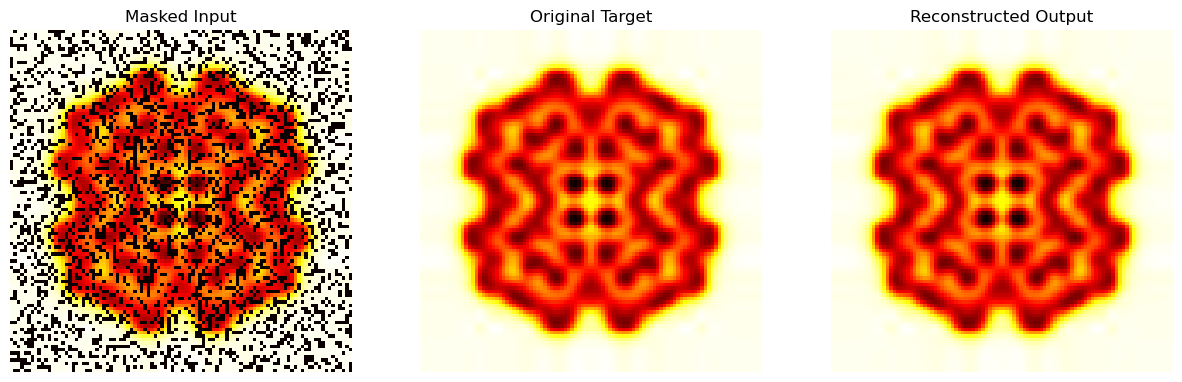

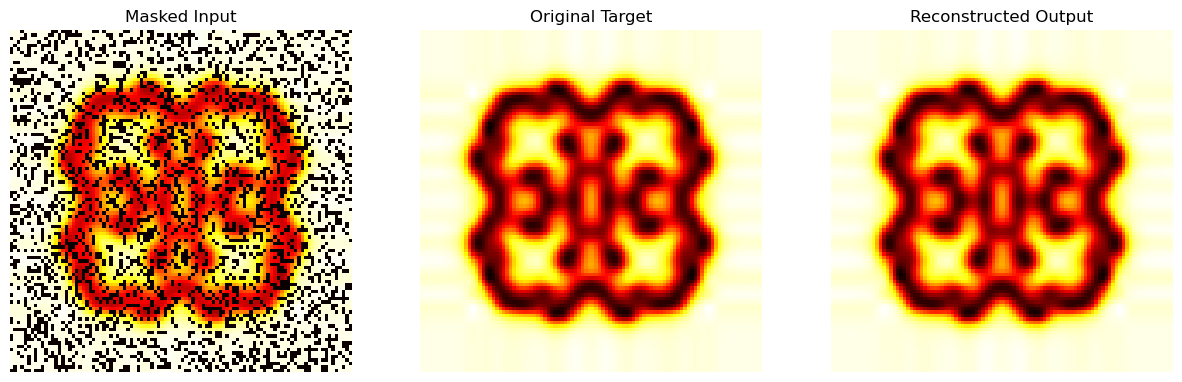

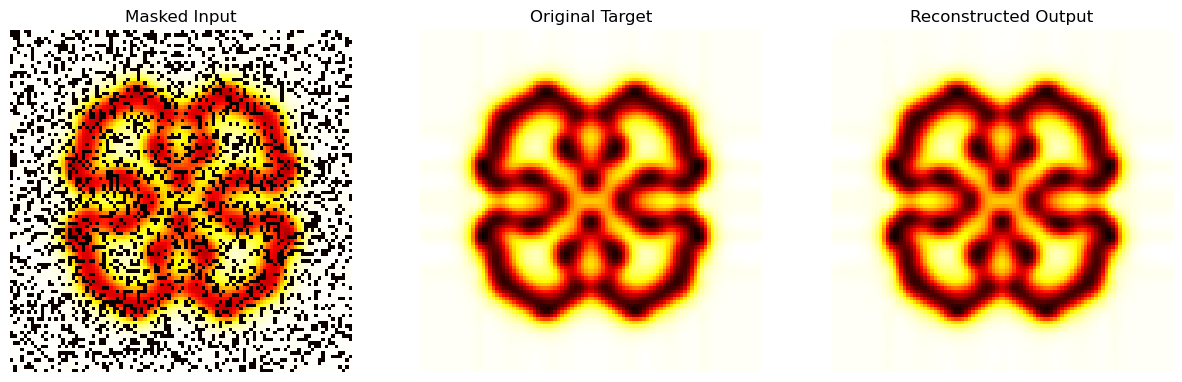

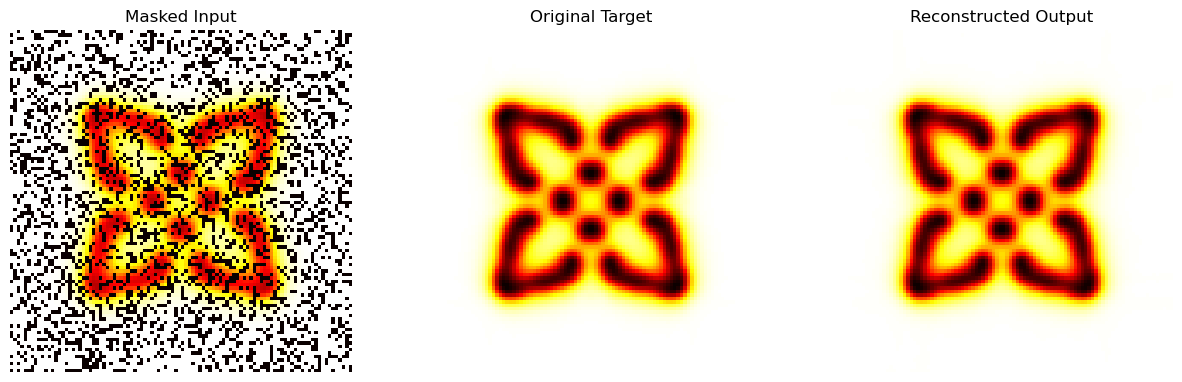

In [20]:
def visualize_results(unet, dataloader, device, num_samples=5):
    unet.eval()  # Set the model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for masked_data, original_data in dataloader:
            # Move data to device
            masked_data = masked_data.to(device)
            original_data = original_data.to(device)
            print(masked_data.shape, original_data.shape)
            # Model prediction
            output = unet(masked_data)

            # Move data back to CPU for visualization
            masked_data = masked_data.cpu().numpy()
            original_data = original_data.cpu().numpy()
            output = output.cpu().numpy()

            # Plot results for the first few samples
            batch_size = masked_data.shape[0]
            for i in range(min(batch_size, num_samples - samples_shown)):
                plt.figure(figsize=(15, 5))

                # Plot masked input
                plt.subplot(1, 3, 1)
                plt.title("Masked Input")
                plt.imshow(masked_data[i, 0], cmap='hot')
                plt.axis('off')

                # Plot original target
                plt.subplot(1, 3, 2)
                plt.title("Original Target")
                plt.imshow(original_data[i, 0], cmap='hot')
                plt.axis('off')

                # Plot reconstructed output
                plt.subplot(1, 3, 3)
                plt.title("Reconstructed Output")
                plt.imshow(output[i, 0], cmap='hot')
                plt.axis('off')
                plt.savefig('./figures/masked_tt_GS_model_t=1250_pretraining.png')
                plt.show()

                samples_shown += 1
                if samples_shown >= num_samples:
                    return

# Call the visualization function after pretraining
visualize_results(unet, train_masked_dataloader, device, num_samples=5)


In [16]:
from torch import save
train_losses = []
validation_losses = []
for epoch in trange(0, num_epochs):
    unet.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_dataloader):
    
        #output = unet(data.view(-1, *data.shape[2:]) )
        output = unet(data)
        #loss = criterion(output, target.view(-1, *target.shape[2:]))
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    scheduler.step()

    if epoch % 100 == 0:
        # Log training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.8f}')
        #print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.8f}')
        train_losses.append(running_loss / len(train_dataloader))
        #print(output)
        #print(target)

        # Validation phase
        unet.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dataloader):
               
                #output = unet(data.view(-1, *data.shape[2:]) )
                output = unet(data)
                #loss = criterion(output, target.view(-1, *target.shape[2:]))
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_dataloader):.8f}')
        validation_losses.append(val_loss / len(val_dataloader))
        #print(f'Validation Loss: {val_loss:.8f}')
        print('=============================================================================')
        
# # Save model checkpoint
# checkpoint_path = f'unet_epoch_{epoch}.pth'
# save(unet.state_dict(), checkpoint_path)
# print(f'Model saved to {checkpoint_path}')


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [1/10000], Training Loss: 0.41933317


  0%|          | 2/10000 [00:22<25:24:07,  9.15s/it]

Validation Loss: 0.21739375


  1%|          | 102/10000 [00:33<18:21,  8.99it/s] 

Epoch [101/10000], Training Loss: 0.02959928
Validation Loss: 0.03174719


  2%|▏         | 202/10000 [00:44<18:08,  9.01it/s]

Epoch [201/10000], Training Loss: 0.02171365
Validation Loss: 0.02077292


  3%|▎         | 302/10000 [00:55<17:58,  8.99it/s]

Epoch [301/10000], Training Loss: 0.01619268
Validation Loss: 0.01782919


  4%|▍         | 402/10000 [01:06<17:47,  8.99it/s]

Epoch [401/10000], Training Loss: 0.01489731
Validation Loss: 0.01765157


  5%|▌         | 502/10000 [01:17<17:25,  9.08it/s]

Epoch [501/10000], Training Loss: 0.01399792
Validation Loss: 0.01818744


  6%|▌         | 602/10000 [01:28<17:12,  9.10it/s]

Epoch [601/10000], Training Loss: 0.01175227
Validation Loss: 0.01598032


  7%|▋         | 702/10000 [01:39<17:12,  9.00it/s]

Epoch [701/10000], Training Loss: 0.01148794
Validation Loss: 0.01771463


  8%|▊         | 802/10000 [01:50<16:59,  9.03it/s]

Epoch [801/10000], Training Loss: 0.00998399
Validation Loss: 0.01471098


  9%|▉         | 902/10000 [02:00<16:54,  8.97it/s]

Epoch [901/10000], Training Loss: 0.00962062
Validation Loss: 0.01550865


 10%|█         | 1002/10000 [02:12<16:55,  8.86it/s]

Epoch [1001/10000], Training Loss: 0.00926727
Validation Loss: 0.01386145


 11%|█         | 1102/10000 [02:23<16:18,  9.09it/s]

Epoch [1101/10000], Training Loss: 0.00851017
Validation Loss: 0.01439762


 12%|█▏        | 1202/10000 [02:34<16:04,  9.12it/s]

Epoch [1201/10000], Training Loss: 0.00839083
Validation Loss: 0.01527849


 13%|█▎        | 1302/10000 [02:45<16:13,  8.93it/s]

Epoch [1301/10000], Training Loss: 0.00857621
Validation Loss: 0.01457034


 14%|█▍        | 1402/10000 [02:56<15:52,  9.02it/s]

Epoch [1401/10000], Training Loss: 0.00673312
Validation Loss: 0.01323424


 15%|█▌        | 1502/10000 [03:07<19:01,  7.44it/s]

Epoch [1501/10000], Training Loss: 0.00765538
Validation Loss: 0.01431259


 16%|█▌        | 1602/10000 [03:18<16:07,  8.68it/s]

Epoch [1601/10000], Training Loss: 0.00774474
Validation Loss: 0.01609978


 17%|█▋        | 1702/10000 [03:30<15:13,  9.08it/s]

Epoch [1701/10000], Training Loss: 0.00774548
Validation Loss: 0.01409711


 18%|█▊        | 1802/10000 [03:41<15:54,  8.59it/s]

Epoch [1801/10000], Training Loss: 0.00684392
Validation Loss: 0.01414387


 19%|█▉        | 1902/10000 [03:52<14:55,  9.04it/s]

Epoch [1901/10000], Training Loss: 0.00682757
Validation Loss: 0.01427233


 20%|██        | 2002/10000 [04:03<14:42,  9.07it/s]

Epoch [2001/10000], Training Loss: 0.00596965
Validation Loss: 0.01321245


 21%|██        | 2102/10000 [04:14<14:35,  9.03it/s]

Epoch [2101/10000], Training Loss: 0.00683334
Validation Loss: 0.01384827


 22%|██▏       | 2202/10000 [04:25<14:34,  8.92it/s]

Epoch [2201/10000], Training Loss: 0.00673046
Validation Loss: 0.01374891


 23%|██▎       | 2302/10000 [04:36<14:06,  9.09it/s]

Epoch [2301/10000], Training Loss: 0.00643043
Validation Loss: 0.01400619


 24%|██▍       | 2402/10000 [04:47<14:12,  8.92it/s]

Epoch [2401/10000], Training Loss: 0.00637008
Validation Loss: 0.01312913


 25%|██▌       | 2502/10000 [04:58<13:45,  9.08it/s]

Epoch [2501/10000], Training Loss: 0.00620737
Validation Loss: 0.01374073


 26%|██▌       | 2602/10000 [05:09<13:32,  9.10it/s]

Epoch [2601/10000], Training Loss: 0.00627087
Validation Loss: 0.01350726


 27%|██▋       | 2702/10000 [05:20<13:28,  9.03it/s]

Epoch [2701/10000], Training Loss: 0.00600788
Validation Loss: 0.01292171


 28%|██▊       | 2802/10000 [05:31<13:20,  8.99it/s]

Epoch [2801/10000], Training Loss: 0.00569595
Validation Loss: 0.01348628


 29%|██▉       | 2902/10000 [05:42<12:59,  9.10it/s]

Epoch [2901/10000], Training Loss: 0.00594200
Validation Loss: 0.01349260


 30%|███       | 3002/10000 [05:52<12:53,  9.05it/s]

Epoch [3001/10000], Training Loss: 0.00575492
Validation Loss: 0.01341231


 31%|███       | 3102/10000 [06:03<12:46,  9.00it/s]

Epoch [3101/10000], Training Loss: 0.00544615
Validation Loss: 0.01402597


 32%|███▏      | 3202/10000 [06:14<12:29,  9.07it/s]

Epoch [3201/10000], Training Loss: 0.00486263
Validation Loss: 0.01269476


 33%|███▎      | 3302/10000 [06:25<12:21,  9.04it/s]

Epoch [3301/10000], Training Loss: 0.00490648
Validation Loss: 0.01326956


 34%|███▍      | 3402/10000 [06:36<12:08,  9.06it/s]

Epoch [3401/10000], Training Loss: 0.00565500
Validation Loss: 0.01334094


 35%|███▌      | 3502/10000 [06:47<11:51,  9.13it/s]

Epoch [3501/10000], Training Loss: 0.00534297
Validation Loss: 0.01293840


 36%|███▌      | 3602/10000 [06:58<11:40,  9.13it/s]

Epoch [3601/10000], Training Loss: 0.00504576
Validation Loss: 0.01332430


 37%|███▋      | 3702/10000 [07:09<11:34,  9.07it/s]

Epoch [3701/10000], Training Loss: 0.00530209
Validation Loss: 0.01326332


 38%|███▊      | 3802/10000 [07:19<11:18,  9.13it/s]

Epoch [3801/10000], Training Loss: 0.00472609
Validation Loss: 0.01261804


 39%|███▉      | 3902/10000 [07:30<11:07,  9.14it/s]

Epoch [3901/10000], Training Loss: 0.00505391
Validation Loss: 0.01276291


 40%|████      | 4002/10000 [07:41<11:09,  8.96it/s]

Epoch [4001/10000], Training Loss: 0.00534387
Validation Loss: 0.01312461


 41%|████      | 4102/10000 [07:53<10:49,  9.08it/s]

Epoch [4101/10000], Training Loss: 0.00537629
Validation Loss: 0.01289437


 42%|████▏     | 4202/10000 [08:04<10:40,  9.05it/s]

Epoch [4201/10000], Training Loss: 0.00513180
Validation Loss: 0.01290393


 43%|████▎     | 4302/10000 [08:15<10:48,  8.79it/s]

Epoch [4301/10000], Training Loss: 0.00496424
Validation Loss: 0.01301894


 44%|████▍     | 4402/10000 [08:26<10:24,  8.97it/s]

Epoch [4401/10000], Training Loss: 0.00493035
Validation Loss: 0.01331059


 45%|████▌     | 4502/10000 [08:37<10:07,  9.04it/s]

Epoch [4501/10000], Training Loss: 0.00481704
Validation Loss: 0.01337619


 46%|████▌     | 4602/10000 [08:48<10:04,  8.92it/s]

Epoch [4601/10000], Training Loss: 0.00490438
Validation Loss: 0.01339884


 47%|████▋     | 4702/10000 [08:59<10:03,  8.78it/s]

Epoch [4701/10000], Training Loss: 0.00440450
Validation Loss: 0.01255164


 48%|████▊     | 4802/10000 [09:10<09:31,  9.09it/s]

Epoch [4801/10000], Training Loss: 0.00435608
Validation Loss: 0.01261474


 49%|████▉     | 4902/10000 [09:21<09:20,  9.09it/s]

Epoch [4901/10000], Training Loss: 0.00447325
Validation Loss: 0.01312802


 50%|█████     | 5002/10000 [09:32<09:11,  9.06it/s]

Epoch [5001/10000], Training Loss: 0.00464263
Validation Loss: 0.01319397


 51%|█████     | 5102/10000 [09:43<09:03,  9.00it/s]

Epoch [5101/10000], Training Loss: 0.00451960
Validation Loss: 0.01275385


 52%|█████▏    | 5202/10000 [09:54<10:33,  7.57it/s]

Epoch [5201/10000], Training Loss: 0.00455319
Validation Loss: 0.01271750


 53%|█████▎    | 5302/10000 [10:06<08:45,  8.93it/s]

Epoch [5301/10000], Training Loss: 0.00426636
Validation Loss: 0.01258771


 54%|█████▍    | 5402/10000 [10:17<08:30,  9.01it/s]

Epoch [5401/10000], Training Loss: 0.00435929
Validation Loss: 0.01256894


 55%|█████▌    | 5502/10000 [10:29<08:34,  8.74it/s]

Epoch [5501/10000], Training Loss: 0.00442270
Validation Loss: 0.01257954


 56%|█████▌    | 5602/10000 [10:41<08:15,  8.88it/s]

Epoch [5601/10000], Training Loss: 0.00436575
Validation Loss: 0.01277499


 57%|█████▋    | 5702/10000 [10:53<09:07,  7.85it/s]

Epoch [5701/10000], Training Loss: 0.00430965
Validation Loss: 0.01296024


 58%|█████▊    | 5802/10000 [11:06<17:43,  3.95it/s]

Epoch [5801/10000], Training Loss: 0.00423177
Validation Loss: 0.01269045


 59%|█████▉    | 5902/10000 [11:28<14:07,  4.84it/s]

Epoch [5901/10000], Training Loss: 0.00412421
Validation Loss: 0.01259055


 60%|██████    | 6002/10000 [11:42<07:34,  8.79it/s]

Epoch [6001/10000], Training Loss: 0.00408595
Validation Loss: 0.01288032


 61%|██████    | 6102/10000 [11:53<07:09,  9.08it/s]

Epoch [6101/10000], Training Loss: 0.00419481
Validation Loss: 0.01249655


 62%|██████▏   | 6202/10000 [12:04<07:00,  9.03it/s]

Epoch [6201/10000], Training Loss: 0.00399963
Validation Loss: 0.01254748


 63%|██████▎   | 6302/10000 [12:16<06:48,  9.06it/s]

Epoch [6301/10000], Training Loss: 0.00406007
Validation Loss: 0.01276215


 64%|██████▍   | 6402/10000 [12:27<06:35,  9.11it/s]

Epoch [6401/10000], Training Loss: 0.00396100
Validation Loss: 0.01252204


 65%|██████▌   | 6502/10000 [12:38<06:32,  8.91it/s]

Epoch [6501/10000], Training Loss: 0.00390086
Validation Loss: 0.01263788


 66%|██████▌   | 6602/10000 [12:50<06:47,  8.34it/s]

Epoch [6601/10000], Training Loss: 0.00392481
Validation Loss: 0.01258561


 67%|██████▋   | 6702/10000 [13:01<06:05,  9.03it/s]

Epoch [6701/10000], Training Loss: 0.00399855
Validation Loss: 0.01254137


 68%|██████▊   | 6802/10000 [13:13<08:54,  5.98it/s]

Epoch [6801/10000], Training Loss: 0.00390968
Validation Loss: 0.01267199


 69%|██████▉   | 6902/10000 [13:25<06:34,  7.85it/s]

Epoch [6901/10000], Training Loss: 0.00384329
Validation Loss: 0.01261877


 70%|███████   | 7002/10000 [13:37<05:38,  8.86it/s]

Epoch [7001/10000], Training Loss: 0.00391510
Validation Loss: 0.01261019


 71%|███████   | 7102/10000 [13:48<05:22,  8.98it/s]

Epoch [7101/10000], Training Loss: 0.00378936
Validation Loss: 0.01249469


 72%|███████▏  | 7202/10000 [13:59<05:08,  9.06it/s]

Epoch [7201/10000], Training Loss: 0.00384188
Validation Loss: 0.01257158


 73%|███████▎  | 7302/10000 [14:11<05:01,  8.95it/s]

Epoch [7301/10000], Training Loss: 0.00373625
Validation Loss: 0.01251806


 74%|███████▍  | 7402/10000 [14:23<05:54,  7.33it/s]

Epoch [7401/10000], Training Loss: 0.00374081
Validation Loss: 0.01258430


 75%|███████▌  | 7502/10000 [14:34<04:41,  8.88it/s]

Epoch [7501/10000], Training Loss: 0.00375190
Validation Loss: 0.01252026


 76%|███████▌  | 7602/10000 [14:45<04:27,  8.97it/s]

Epoch [7601/10000], Training Loss: 0.00368554
Validation Loss: 0.01246620


 77%|███████▋  | 7702/10000 [14:56<04:19,  8.87it/s]

Epoch [7701/10000], Training Loss: 0.00370864
Validation Loss: 0.01251108


 78%|███████▊  | 7802/10000 [15:08<04:05,  8.96it/s]

Epoch [7801/10000], Training Loss: 0.00370889
Validation Loss: 0.01248273


 99%|█████████▉| 9902/10000 [19:01<00:10,  9.01it/s]

Epoch [9901/10000], Training Loss: 0.00353342
Validation Loss: 0.01250665


100%|██████████| 10000/10000 [19:11<00:00,  8.68it/s]


In [ ]:
plt.semilogy(train_losses, label='training')
plt.semilogy(validation_losses, label='validation')
plt.legend()

In [ ]:
checkpoint_path = f'unet_GS_random_IC_masked_tt_GS_model_t=1250_without_pretraining.pth'
save(unet.state_dict(), checkpoint_path)
print(f'Model saved to {checkpoint_path}')

Model saved to unet_GS_random_IC_masked_tt_GS_model_t=1250_without_pretraining.pth


In [15]:
input_CG_test = input_CG[train_window:]  
target_FG_test = target_FG[train_window:]  

In [16]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [17]:
input_CG_test_tensor.shape, target_FG_test_tensor.shape

(torch.Size([50, 1, 48, 48]), torch.Size([50, 1, 128, 128]))

In [18]:
unet.eval().cpu()

OptimizedModule(
  (_orig_mod): UNet(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (middle): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up2): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3)

In [19]:
predictions = []
targets = []
inputs = []  
output_dim = 128
with torch.no_grad():
 
    batch_size = 64
    for i in range(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]

       
        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = unet(data)  
     
        #print(f"Output shape before reshaping: {output.shape}")

        #output = output.view(output.shape[0], 1, output_dim, output_dim)  

       
        predictions.append(output.numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy())  
 

In [20]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

Sample 1 - MAE (Prediction vs Target): 0.0008
Sample 1 - MAE (Input Upsampled vs Target): 0.2834
Sample 2 - MAE (Prediction vs Target): 0.0069
Sample 2 - MAE (Input Upsampled vs Target): 0.2825
Sample 3 - MAE (Prediction vs Target): 0.0222
Sample 3 - MAE (Input Upsampled vs Target): 0.2807
Sample 4 - MAE (Prediction vs Target): 0.0635
Sample 4 - MAE (Input Upsampled vs Target): 0.2772


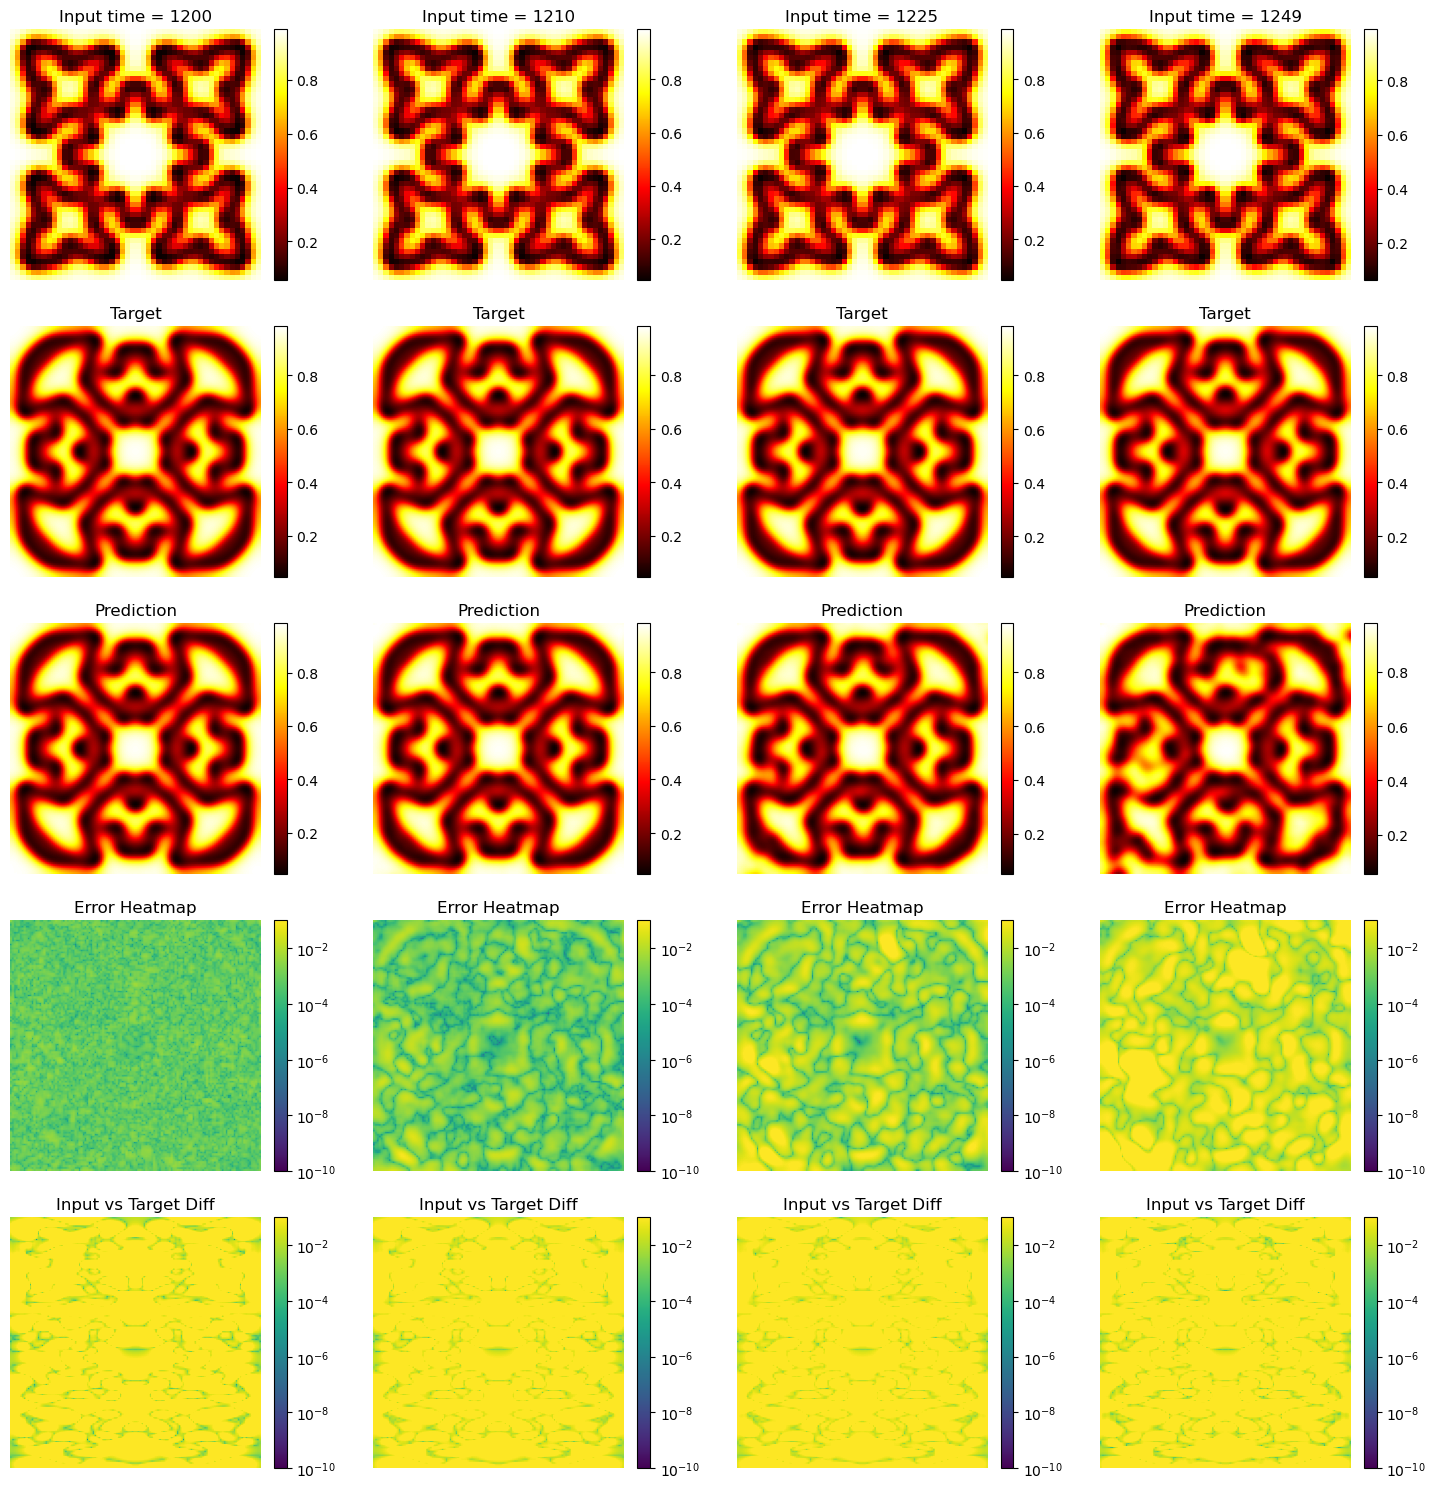

In [21]:
from scipy.ndimage import zoom
# Example input data dimensions
num_samples = 4  # Number of samples to visualize
indices = [0, 10, 25, 49]
plt.figure(figsize=(15, 15))  # Adjusted figure size for additional row

for i, idx in enumerate(indices):
    # Plot the input
    ax = plt.subplot(5, num_samples, i + 1)
    im = ax.imshow(inputs[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Input time = ' +str( idx + train_window + 500))
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input

    # Plot the target
    ax = plt.subplot(5, num_samples, i + 1 + num_samples)
    im = ax.imshow(targets[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Target')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for target

    # Plot the prediction
    ax = plt.subplot(5, num_samples, i + 1 + 2 * num_samples)
    im = ax.imshow(predictions[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for prediction

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for error heatmap

     # Compute and print MAE for prediction vs target
    mae_prediction_target = np.mean(error)
    print(f"Sample {i+1} - MAE (Prediction vs Target): {mae_prediction_target:.4f}")

    # Bilinear interpolation to upsample the input to the target's size
    input_upsampled = zoom(inputs[idx, 0], (targets.shape[1] / inputs.shape[1], targets.shape[2] / inputs.shape[2]), order=1)

    # Ensure that the output dimensions match exactly by resizing using cv2
    input_upsampled = np.resize(input_upsampled, targets[idx, 0].shape)

    # Plot the absolute difference between the upsampled input and target
    input_target_diff = np.abs(input_upsampled - targets[idx, 0])
    #input_target_diff = np.abs(inputs[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 4 * num_samples)
    im = ax.imshow(input_target_diff, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Input vs Target error
    plt.title('Input vs Target Diff')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input vs target diff

    # Compute and print MAE for upsampled input vs target
    mae_input_target = np.mean(input_target_diff)
    print(f"Sample {i+1} - MAE (Input Upsampled vs Target): {mae_input_target:.4f}")

plt.tight_layout()
# plt.savefig('vit_2d_vlasov_model_test_result_qtt_masked_MHSAP.png')
#plt.savefig('./figures/unet_GS_model_test_result_bilinear_single_traj.png')

In [29]:
# # Example indices and data
# #indices =   # Chosen indices
# import imageio
# gif_frames = []  # To store frames for the GIF

# # Specify output GIF file
# output_gif = './figures/unet_GS_model_test_animation.gif'

# # Loop over indices to create frames
# for idx in range(predictions.shape[0]):
#     fig, ax = plt.subplots(1, 3, figsize=(12, 4))

#     # Plot the target
#     im_target = ax[0].imshow(targets[idx, 0], cmap='hot')
#     ax[0].set_title('Target')
#     ax[0].axis('off')
#     plt.colorbar(im_target, ax=ax[0], fraction=0.046, pad=0.04)

#     # Plot the prediction
#     im_prediction = ax[1].imshow(predictions[idx, 0], cmap='hot')
#     ax[1].set_title('Prediction')
#     ax[1].axis('off')
#     plt.colorbar(im_prediction, ax=ax[1], fraction=0.046, pad=0.04)

#     # Plot the absolute error (prediction - target)
#     error = np.abs(predictions[idx, 0] - targets[idx, 0])
#     im_error = ax[2].imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))
#     ax[2].set_title('Error Heatmap')
#     ax[2].axis('off')
#     plt.colorbar(im_error, ax=ax[2], fraction=0.046, pad=0.04)

#     plt.tight_layout()

#     # Save the figure as a temporary file
#     temp_filename = f'./figures/temp_frame_{idx}.png'
#     plt.savefig(temp_filename)
#     plt.close()

#     # Read the file into a frame for the GIF
#     gif_frames.append(imageio.imread(temp_filename))

# # Save the frames as a GIF
# imageio.mimsave(output_gif, gif_frames, fps=5)  # Set FPS (frames per second)
# print(f"GIF saved to {output_gif}")

In [16]:
input_CG_test = input_CG[:train_window]  
target_FG_test = target_FG[:train_window]

In [17]:
input_CG_test_tensor = torch.tensor(input_CG_test, dtype=torch.float32)
target_FG_test_tensor = torch.tensor(target_FG_test, dtype=torch.float32)

In [21]:
unet.eval().cpu()

OptimizedModule(
  (_orig_mod): UNet(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (middle): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (up2): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (dec2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3)

In [22]:
predictions = []
targets = []
inputs = []  

In [23]:
output_dim = 128
with torch.no_grad():
    batch_size = 1
    for i in trange(0, input_CG_test_tensor.shape[0], batch_size):
        data = input_CG_test_tensor[i:i + batch_size]
        target = target_FG_test_tensor[i:i + batch_size]


        #print(f"Batch Data shape: {data.shape}, Target shape: {target.shape}")

        output = unet(data) 
    
        #print(f"Output shape before reshaping: {output.shape}")

        output = output.view(output.shape[0], 1, output_dim, output_dim)  

        
        predictions.append(output.cpu().numpy())
        targets.append(target.numpy())
        inputs.append(data.numpy()) 

  0%|          | 0/85 [00:00<?, ?it/s]


ValueError: Pointer argument (at 0) cannot be accessed from Triton (cpu tensor?)

In [ ]:
# Convert predictions, targets, and inputs to numpy arrays
predictions = np.concatenate(predictions, axis=0)  
targets = np.concatenate(targets, axis=0)  
inputs = np.concatenate(inputs, axis=0)  

In [ ]:
from scipy.ndimage import zoom

# Example input data dimensions
# num_samples = 4  # Number of samples to visualize
indices =  [52, 69, 57, 49]
num_samples = 4  # Number of samples to visualize
#indices = [100, 250, 500, 690]

plt.figure(figsize=(15, 15))  # Adjusted figure size for additional row

for i, idx in enumerate(indices):
    # Plot the input
    ax = plt.subplot(5, num_samples, i + 1)
    im = ax.imshow(inputs[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Input time = ' +str( idx ))
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input

    # Plot the target
    ax = plt.subplot(5, num_samples, i + 1 + num_samples)
    im = ax.imshow(targets[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Target')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for target

    # Plot the prediction
    ax = plt.subplot(5, num_samples, i + 1 + 2 * num_samples)
    im = ax.imshow(predictions[idx, 0], cmap='hot')  # Use the first channel
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for prediction

    # Calculate the error and plot the error heatmap with color bar
    error = np.abs(predictions[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 3 * num_samples)
    im = ax.imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Error heatmap
    plt.title('Error Heatmap')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for error heatmap

    # Compute and print MAE for prediction vs target
    mae_prediction_target = np.mean(error)
    print(f"Sample {i+1} - MAE (Prediction vs Target): {mae_prediction_target:.4f}")

    # Bilinear interpolation to upsample the input to the target's size
    input_upsampled = zoom(inputs[idx, 0], (targets.shape[1] / inputs.shape[1], targets.shape[2] / inputs.shape[2]), order=1)

    # Ensure that the output dimensions match exactly by resizing using cv2
    input_upsampled = np.resize(input_upsampled, targets[idx, 0].shape)

    # Plot the absolute difference between the upsampled input and target
    input_target_diff = np.abs(input_upsampled - targets[idx, 0])
    #input_target_diff = np.abs(inputs[idx, 0] - targets[idx, 0])
    ax = plt.subplot(5, num_samples, i + 1 + 4 * num_samples)
    im = ax.imshow(input_target_diff, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))  # Input vs Target error
    plt.title('Input vs Target Diff')
    plt.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Colorbar for input vs target diff

    # Compute and print MAE for upsampled input vs target
    mae_input_target = np.mean(input_target_diff)
    print(f"Sample {i+1} - MAE (Input vs Target): {mae_input_target:.4f}")
    print("========================================================================================")

plt.tight_layout()
#plt.savefig('unet_GS_model_training_result_single_traj.png')

In [38]:
predictions.shape, inputs.shape, targets.shape

((700, 1, 128, 128), (700, 1, 48, 48), (700, 1, 128, 128))

In [45]:
time_indices = indices
def compute_power_spectrum(image):
    fft_image = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_image)
    power_spectrum = np.abs(fft_shifted)**2
    return np.log(1 + power_spectrum)  

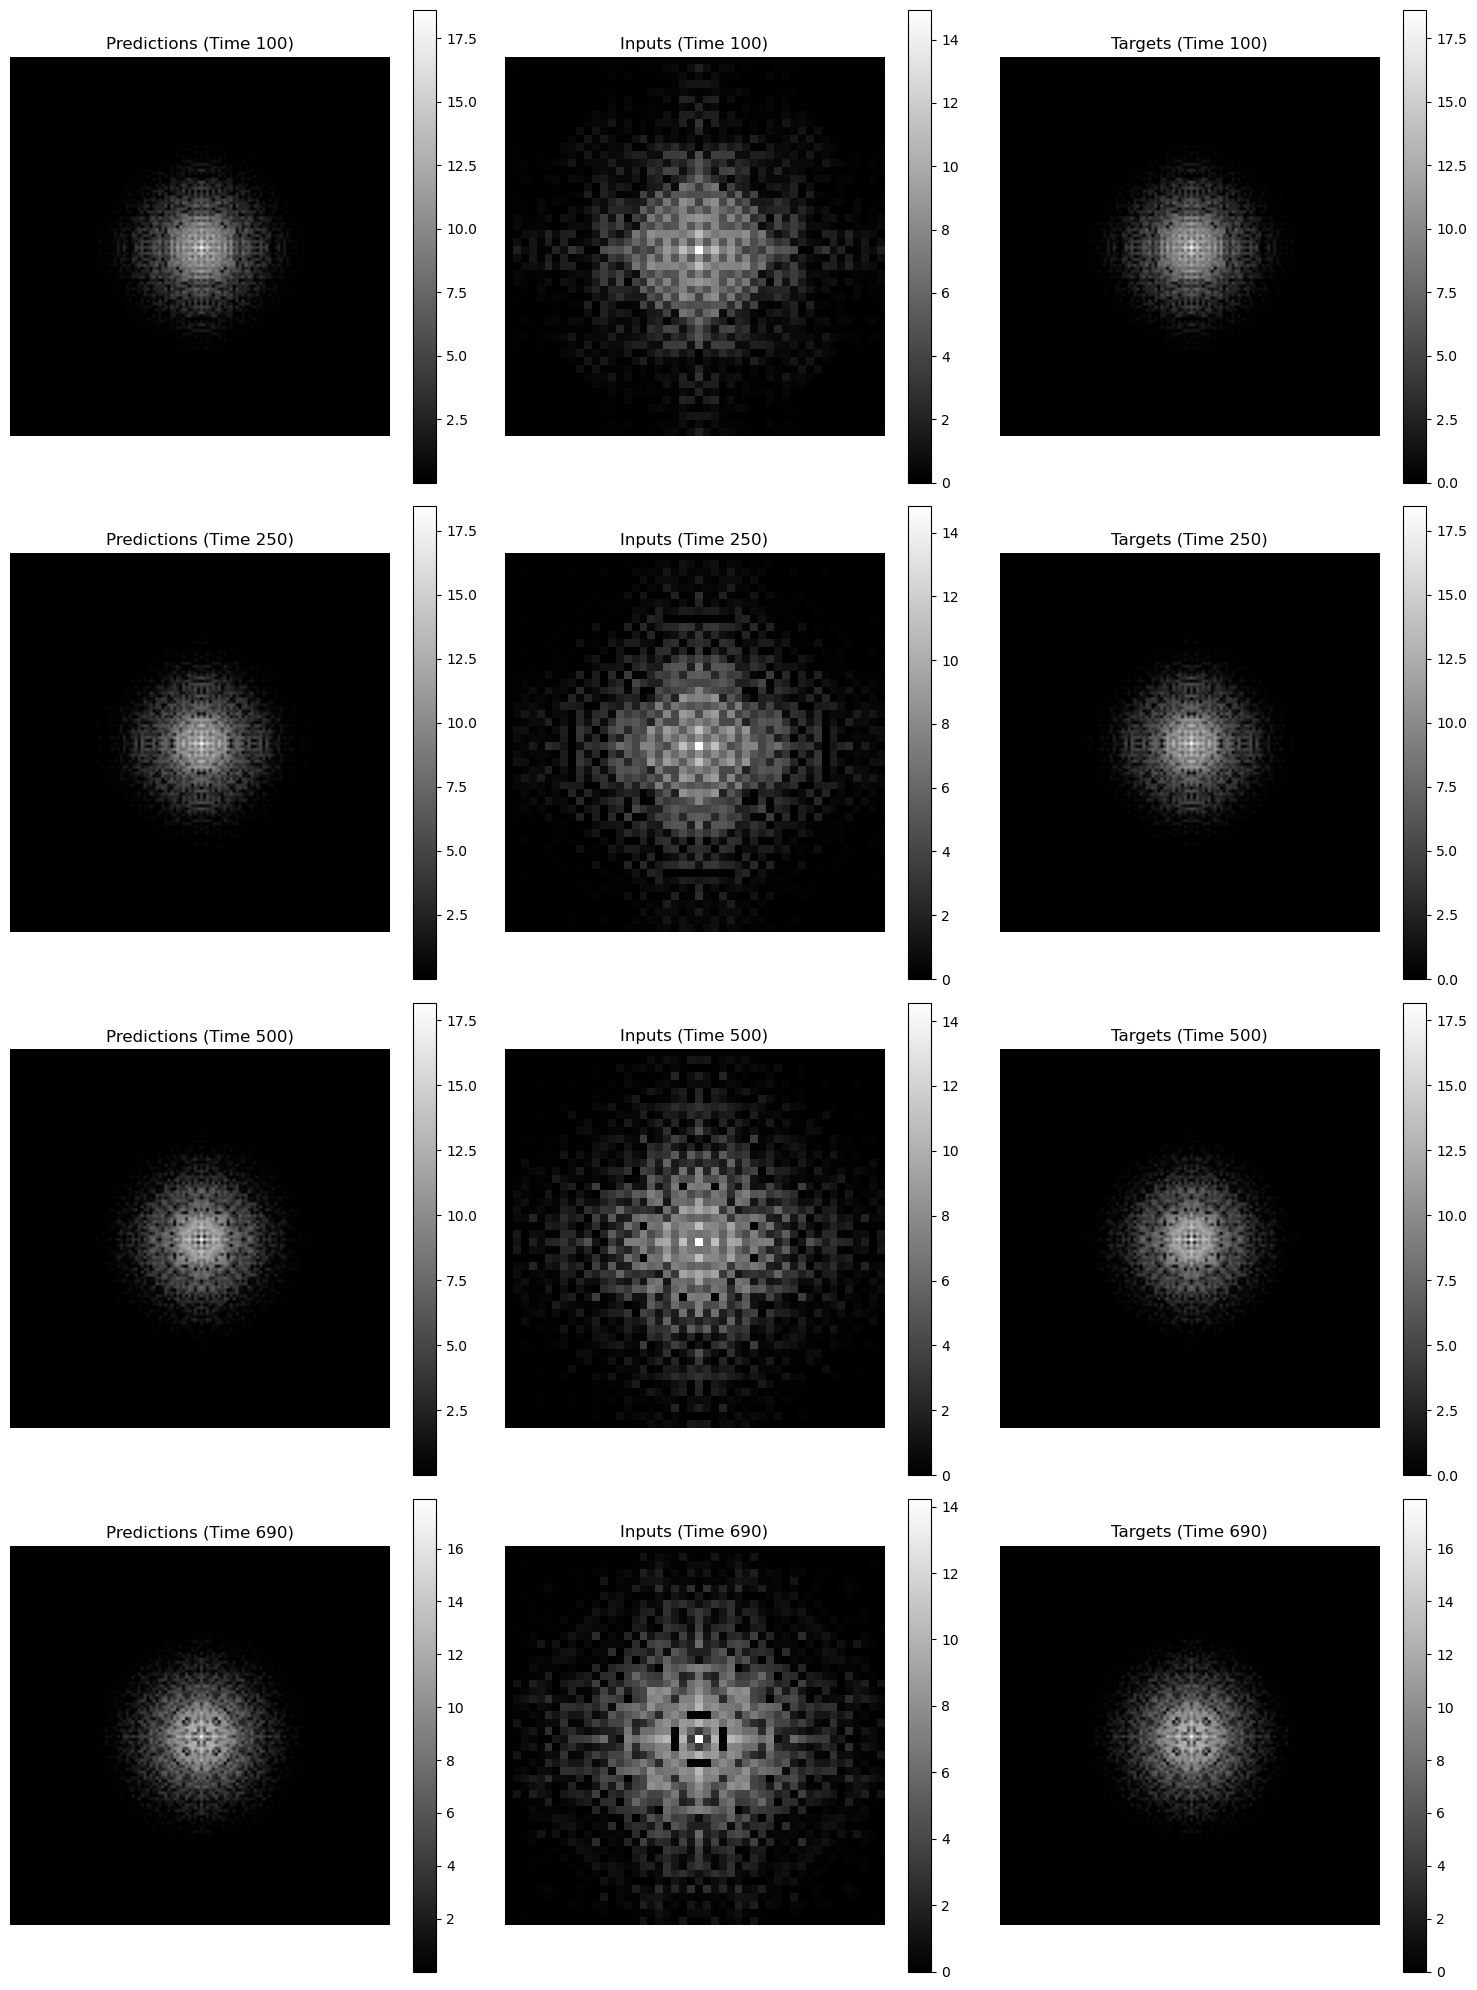

In [51]:
def plot_power_spectra(time_indices, predictions, inputs, targets):
    fig, axes = plt.subplots(len(time_indices), 3, figsize=(15, len(time_indices) * 5))

    for i, time_idx in enumerate(time_indices):
        # Extract images at the given time index
        pred_img = predictions[time_idx, 0, :, :]
        input_img = inputs[time_idx, 0, :, :]
        target_img = targets[time_idx, 0, :, :]

        # Compute power spectra
        pred_ps = compute_power_spectrum(pred_img)
        input_ps = compute_power_spectrum(input_img)
        target_ps = compute_power_spectrum(target_img)

        # Plot power spectra side by side with color bars
        im0 = axes[i, 0].imshow(pred_ps, cmap='gray')
        axes[i, 0].set_title(f"Predictions (Time {time_idx})")
        axes[i, 0].axis('off')
        fig.colorbar(im0, ax=axes[i, 0], orientation='vertical')

        im1 = axes[i, 1].imshow(input_ps, cmap='gray')
        axes[i, 1].set_title(f"Inputs (Time {time_idx})")
        axes[i, 1].axis('off')
        fig.colorbar(im1, ax=axes[i, 1], orientation='vertical')

        im2 = axes[i, 2].imshow(target_ps, cmap='gray')
        axes[i, 2].set_title(f"Targets (Time {time_idx})")
        axes[i, 2].axis('off')
        fig.colorbar(im2, ax=axes[i, 2], orientation='vertical')

    plt.tight_layout()
    plt.savefig('./figures/single_traj_GS_fixed_IC_unet_power_spectrum.png')
    plt.show()

# Plot the power spectra with color bars
plot_power_spectra(time_indices, predictions, inputs, targets)

(128, 128) (48, 48) (128, 128)
(91,) (34,) (91,)
(128, 128) (48, 48) (128, 128)
(91,) (34,) (91,)
(128, 128) (48, 48) (128, 128)
(91,) (34,) (91,)
(128, 128) (48, 48) (128, 128)
(91,) (34,) (91,)


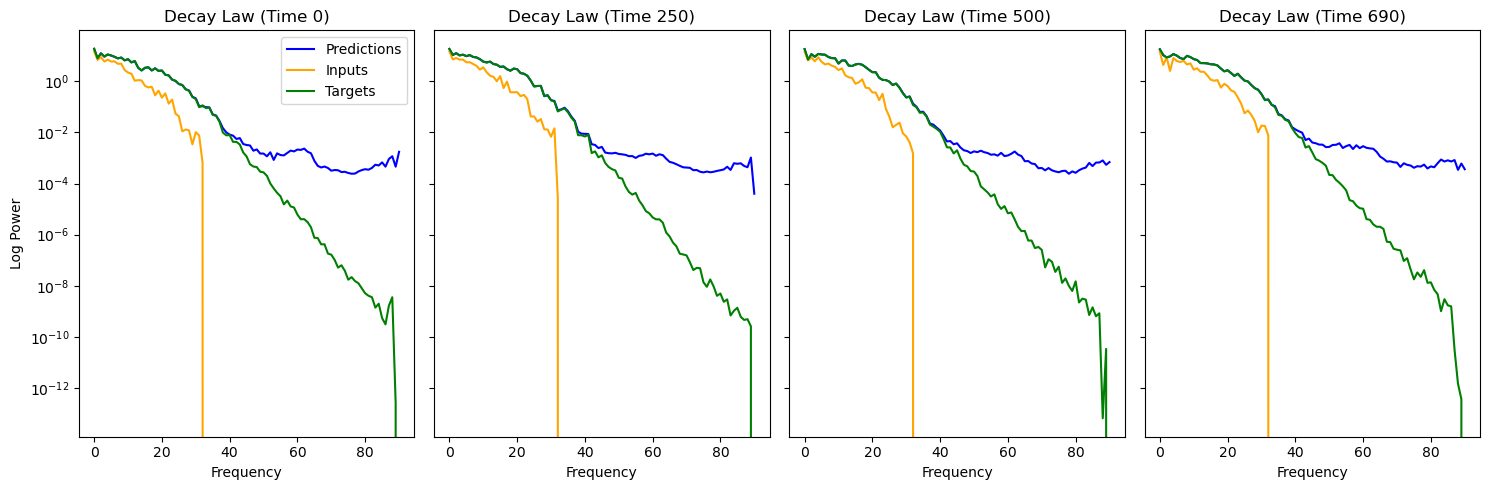

In [52]:
def compute_radial_profile(power_spectrum):
    y, x = np.indices(power_spectrum.shape)
    center = np.array([power_spectrum.shape[0] // 2, power_spectrum.shape[1] // 2])

    # Compute radial distance from the center
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    r = r.astype(np.int32)

    # Radially average the power spectrum
    radial_mean = np.bincount(r.ravel(), power_spectrum.ravel()) / np.bincount(r.ravel())
    return radial_mean

def plot_decay_laws(time_indices, predictions, inputs, targets):
    fig, axes = plt.subplots(1, len(time_indices), figsize=(15, 5), sharey=True)

    for i, time_idx in enumerate(time_indices):
        # Extract images at the given time index
        pred_img = predictions[time_idx, 0, :, :]
        input_img = inputs[time_idx, 0, :, :]
        target_img = targets[time_idx, 0, :, :]

        # Compute power spectra
        pred_ps = compute_power_spectrum(pred_img)
        input_ps = compute_power_spectrum(input_img)
        target_ps = compute_power_spectrum(target_img)
        print(pred_ps.shape, input_ps.shape, target_ps.shape)
        # Compute radially averaged power spectra
        pred_radial = compute_radial_profile(pred_ps)
        input_radial = compute_radial_profile(input_ps)
        target_radial = compute_radial_profile(target_ps)
        print(pred_radial.shape, input_radial.shape, target_radial.shape)
        # Plot decay laws
        axes[i].plot(pred_radial, label="Predictions", color="blue")
        axes[i].plot(input_radial, label="Inputs", color="orange")
        axes[i].plot(target_radial, label="Targets", color="green")
        axes[i].set_title(f"Decay Law (Time {time_idx})")
        axes[i].set_xlabel("Frequency")
        axes[i].set_yscale("log")
        if i == 0:
            axes[i].set_ylabel("Log Power")

    # Add legend
    axes[0].legend()
    plt.tight_layout()
    plt.savefig('./figures/single_traj_GS_fixed_IC_unet_1D_power_spectrum_decay.png')
    plt.show()

# Call the function to plot decay laws
plot_decay_laws([0, 250, 500, 690], predictions, inputs, targets)

Hooked Encoder Layer 1
Hooked Middle Layer (Last Conv)
Layers in dec3: ['Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))', 'ReLU()', 'Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))']
Hooked Decoder Layer (Last Conv)
Activations dictionary contains 3 layers.
Layers hooked: ['Encoder Layer 1', 'Middle Layer (Last Conv)', 'Decoder Layer (Last Conv)']
Visualizing Encoder Layer 1


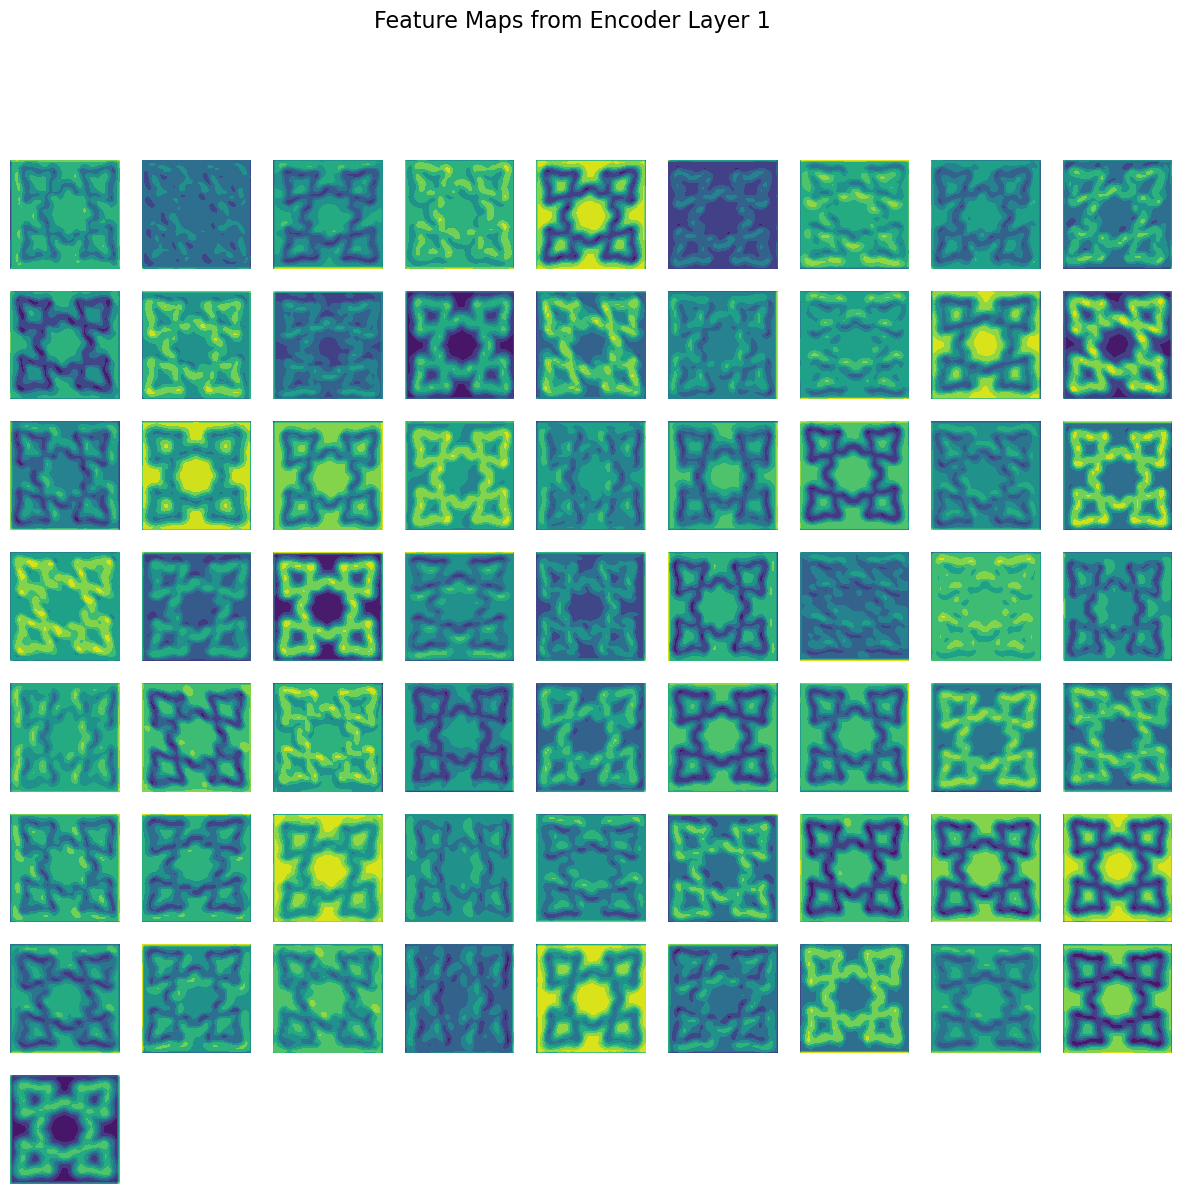

Visualizing Middle Layer (Last Conv)


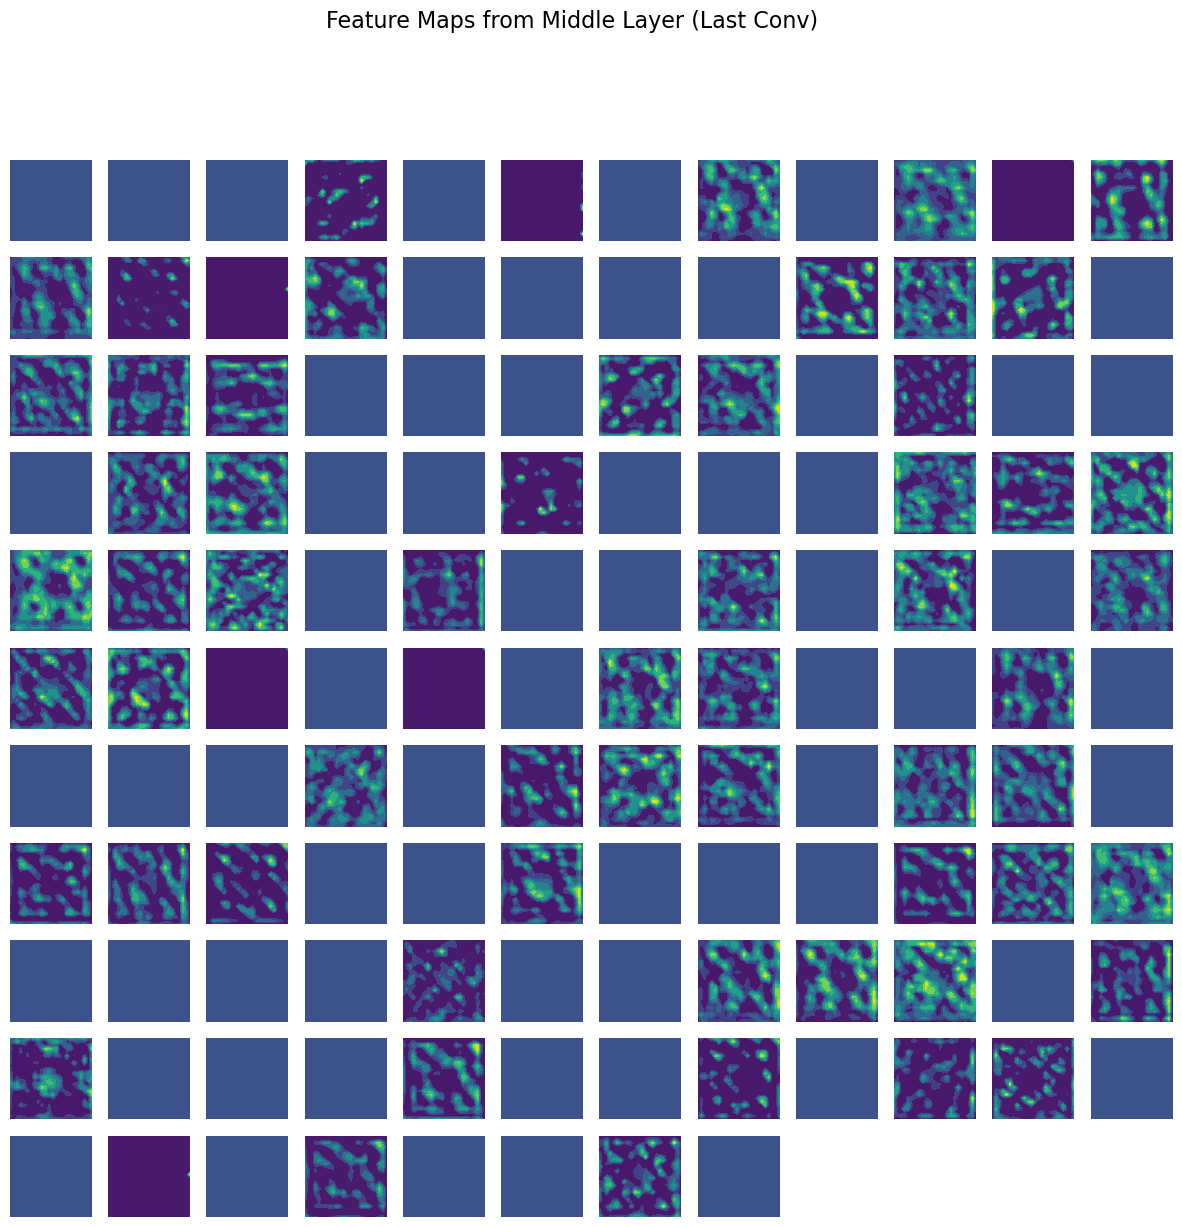

Visualizing Decoder Layer (Last Conv)


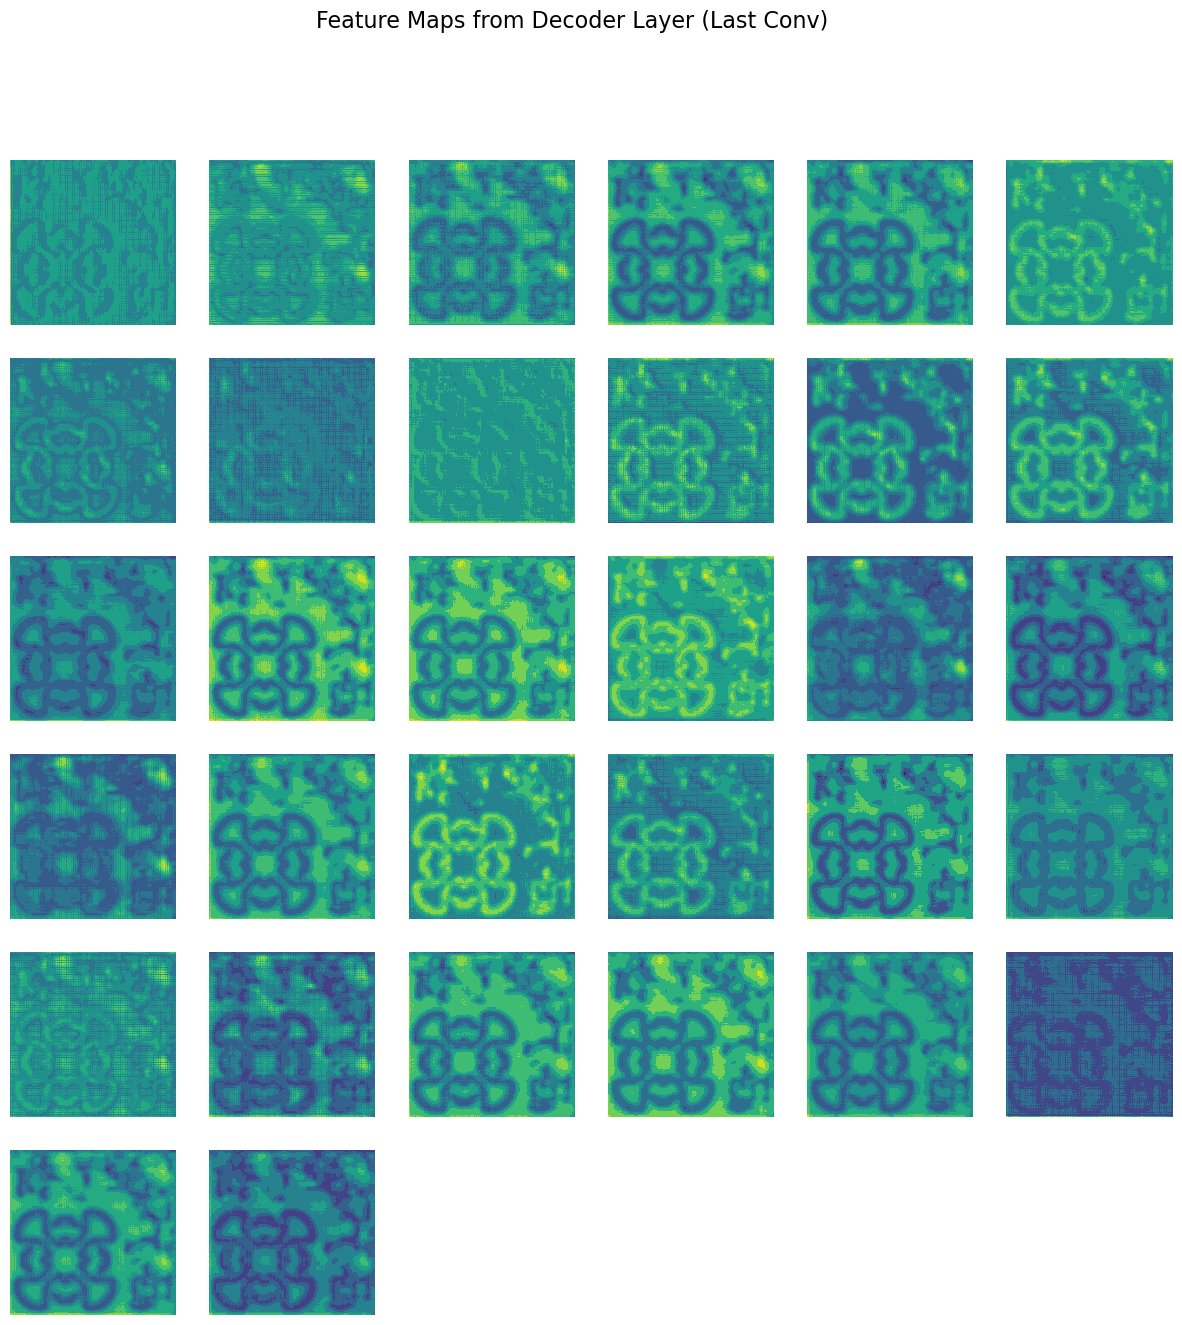

In [27]:
activations = {}

def hook_fn(module_name):
    def inner_hook(module, input, output):
        activations[module_name] = output
    return inner_hook

for module in unet.modules():
    module._forward_hooks.clear()

# Register hooks for specific layers
unet.encoder[0].register_forward_hook(hook_fn("Encoder Layer 1"))  # nn.Conv2d(1, 64, kernel_size=3, padding=1)
print("Hooked Encoder Layer 1")
unet.middle[3].register_forward_hook(hook_fn("Middle Layer (Last Conv)"))  # nn.Conv2d(128, 128, kernel_size=3, padding=1)
print("Hooked Middle Layer (Last Conv)")

# Check layers in dec3
print(f"Layers in dec3: {[str(layer) for layer in unet.dec3]}")

# Register hook on the last Conv2d layer in dec3 (the third layer in dec3)
unet.dec3[0].register_forward_hook(hook_fn("Decoder Layer (Last Conv)"))
print("Hooked Decoder Layer (Last Conv)")

# Pass a sample input through the U-Net
sample_input = torch.tensor(input_CG[550].reshape((1, 1, 48, 48))).float()  
_ = unet(sample_input)

print(f"Activations dictionary contains {len(activations)} layers.")
print(f"Layers hooked: {list(activations.keys())}")

# Visualize the feature maps
def visualize_feature_maps(feature_maps, layer_name):
    num_maps = feature_maps.shape[1]  
    grid_size = int(num_maps**0.5) + 1 
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_maps:
            ax.contourf(feature_maps[0, i].detach().cpu().numpy(), cmap='viridis')  
            ax.axis('off')
        else:
            ax.remove()

    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    plt.savefig(f'feature_map_{layer_name}.png')
    plt.show()

# Visualize the activations for each hooked layer
for layer_name, activation in activations.items():
    print(f"Visualizing {layer_name}")
    visualize_feature_maps(activation, layer_name)


In [ ]:
# # Example indices and data
# #indices =   # Chosen indices
# import imageio
# gif_frames = []  # To store frames for the GIF

# # Specify output GIF file
# output_gif = './figures/unet_GS_model_animation.gif'

# # Loop over indices to create frames
# for idx in range(predictions.shape[0]):
#     fig, ax = plt.subplots(1, 3, figsize=(12, 4))

#     # Plot the target
#     im_target = ax[0].imshow(targets[idx, 0], cmap='hot')
#     ax[0].set_title('Target')
#     ax[0].axis('off')
#     plt.colorbar(im_target, ax=ax[0], fraction=0.046, pad=0.04)

#     # Plot the prediction
#     im_prediction = ax[1].imshow(predictions[idx, 0], cmap='hot')
#     ax[1].set_title('Prediction')
#     ax[1].axis('off')
#     plt.colorbar(im_prediction, ax=ax[1], fraction=0.046, pad=0.04)

#     # Plot the absolute error (prediction - target)
#     error = np.abs(predictions[idx, 0] - targets[idx, 0])
#     im_error = ax[2].imshow(error, cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e-1))
#     ax[2].set_title('Error Heatmap')
#     ax[2].axis('off')
#     plt.colorbar(im_error, ax=ax[2], fraction=0.046, pad=0.04)

#     plt.tight_layout()

#     # Save the figure as a temporary file
#     temp_filename = f'./figures/temp_frame_{idx}.png'
#     plt.savefig(temp_filename)
#     plt.close()

#     # Read the file into a frame for the GIF
#     gif_frames.append(imageio.imread(temp_filename))

# # Save the frames as a GIF
# imageio.mimsave(output_gif, gif_frames, fps=10)  # Set FPS (frames per second)
# print(f"GIF saved to {output_gif}")

Text(0.5, 1.0, 'U-net training/test MAEs')

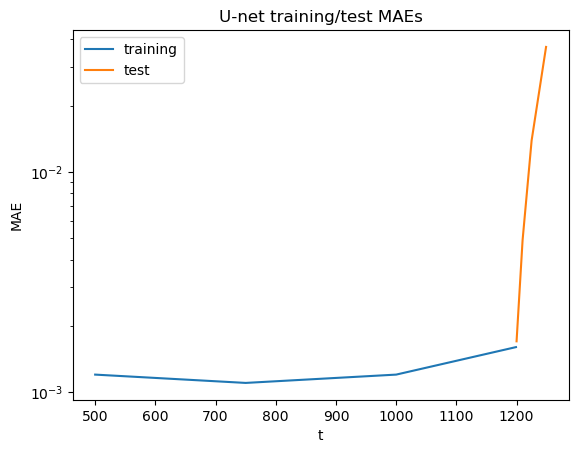

In [29]:
MAE_preds = [0.0012,0.0011, 0.0012, 0.0016]
plt.semilogy(np.array(indices) + 500, MAE_preds)
plt.xlabel('t')
plt.ylabel('MAE')
MAE_preds = [0.0017,0.0049, 0.0139,0.0370]
plt.semilogy(np.array([0, 10, 25, 49]) + 1200 , MAE_preds)
plt.xlabel('t')
plt.ylabel('MAE')
plt.legend(['training', 'test'])
plt.title('U-net training/test MAEs')
#plt.savefig('./figures/unet_GS_model_training_test_result_errors_single_traj.png')